In [60]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [61]:
# Abbrevation for the stocks in S&P500
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S&P_500_companies')[0]['Symbol']

print(tickers)

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object


[*********************100%***********************]  1 of 1 completed
MMM


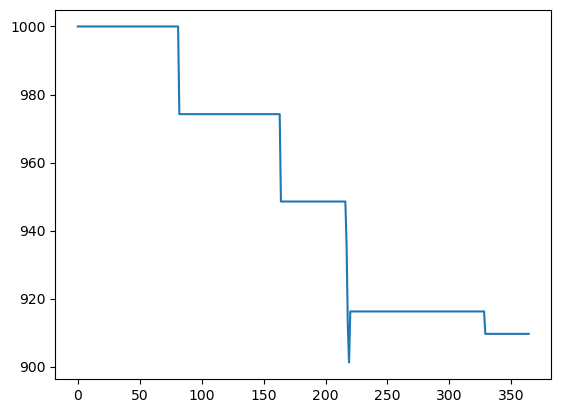

Investing Total: 592.4494335196957 -40.8%
Algo-Trading Total: 909.6179920580144 -9.0%
[*********************100%***********************]  1 of 1 completed
AOS


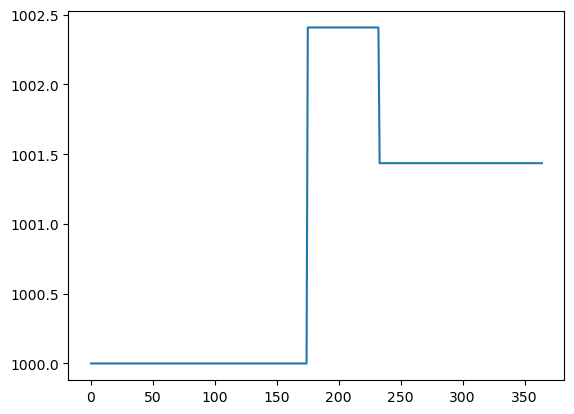

Investing Total: 913.6945764102151 -8.6%
Algo-Trading Total: 1001.4351748628776 0.1%
[*********************100%***********************]  1 of 1 completed
ABT


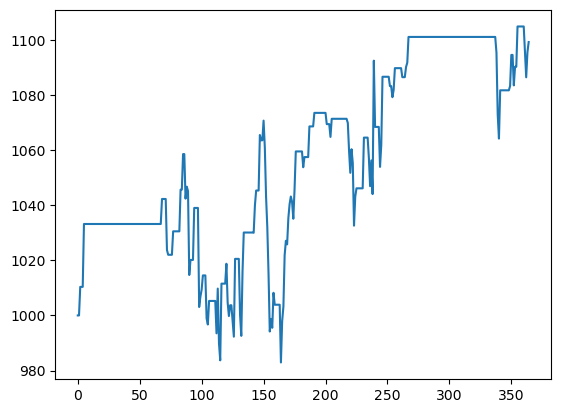

Investing Total: 808.1467628865539 -19.2%
Algo-Trading Total: 1099.186422058528 9.9%
[*********************100%***********************]  1 of 1 completed
ABBV


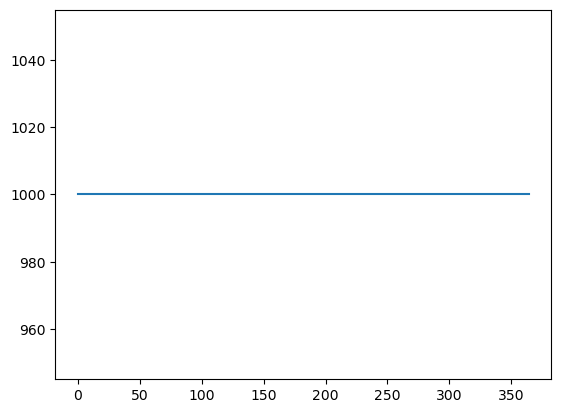

Investing Total: 1402.082397725732 40.2%
Algo-Trading Total: 1000 0.0%
[*********************100%***********************]  1 of 1 completed
ACN


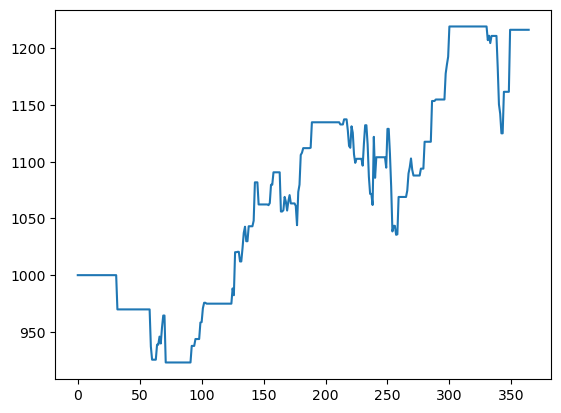

Investing Total: 778.2237004982335 -22.2%
Algo-Trading Total: 1216.3045545459845 21.6%
[*********************100%***********************]  1 of 1 completed
ATVI


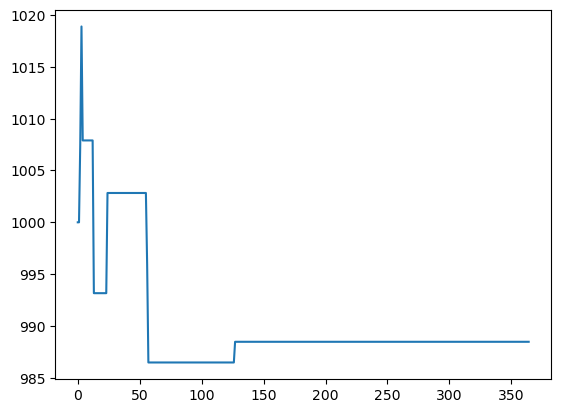

Investing Total: 1080.18740823271 8.0%
Algo-Trading Total: 988.4713591765299 -1.2%
[*********************100%***********************]  1 of 1 completed
ADM


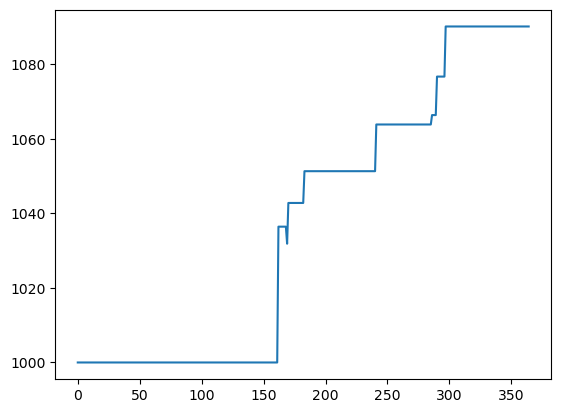

Investing Total: 1267.8654194245016 26.8%
Algo-Trading Total: 1090.151671901027 9.0%
[*********************100%***********************]  1 of 1 completed
ADBE


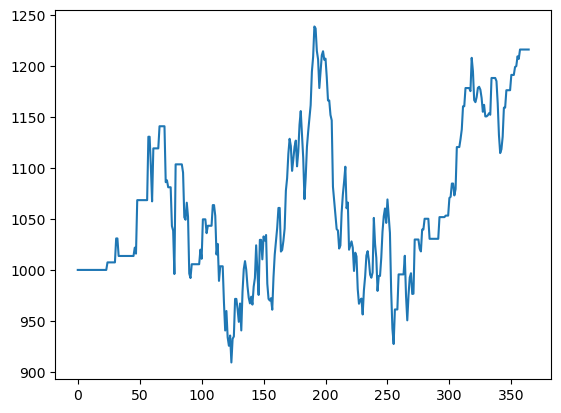

Investing Total: 582.7202396069375 -41.7%
Algo-Trading Total: 1216.2514316016711 21.6%
[*********************100%***********************]  1 of 1 completed
ADP


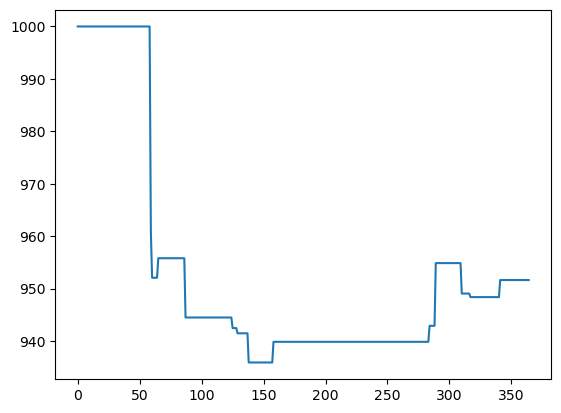

Investing Total: 962.4737689562929 -3.8%
Algo-Trading Total: 951.6123400976253 -4.8%
[*********************100%***********************]  1 of 1 completed
AAP


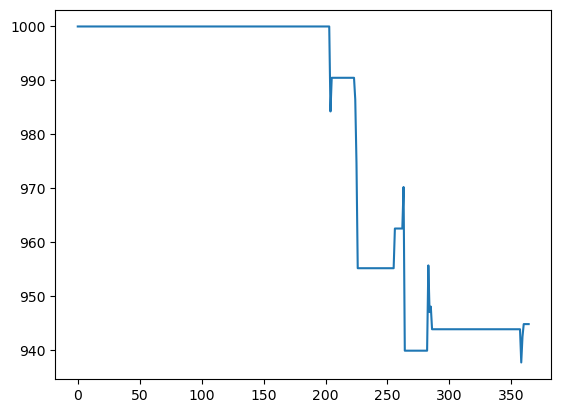

Investing Total: 546.2017859439097 -45.4%
Algo-Trading Total: 944.8054052176493 -5.5%


In [69]:
# Linear Regression to predict
from sklearn.linear_model import LinearRegression

# Test model
def test_it(opens, closes, preds, start_account=1000, thresh=0):
    account = start_account
    changes = []
    
    for i in range(len(preds)):
        if (preds[i]-opens[i])/opens[i] >= thresh:
            account += account*(closes[i]-opens[i])/opens[i]
        changes.append(account)
    changes = np.array(changes)
    
    # Gives graph of account over time
    plt.plot(range(len(changes)), changes)
    plt.show()
    
    invest_total = start_account + start_account*(closes[-1]-opens[0])/opens[0]
    print('Investing Total:', invest_total, str(round((invest_total-start_account)/start_account*100,1))+'%')
    print('Algo-Trading Total:', account, str(round((account-start_account)/start_account*100,1))+'%')

    
    
# MACD indicator - to indicate which way the stock is trending
def calc_macd(data, len1, len2, len3):
    shortEMA = data.ewm(span=len1, adjust=False).mean()
    longEMA = data.ewm(span=len2, adjust=False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span=len3, adjust=False).mean()
    return MACD, signal

# RSI indicator - whether a stock is overbought or oversold
def calc_rsi(data, period):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=period, adjust=False).mean()
    ema_down = down.ewm(com=period, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100/(1+rs))
    return rsi

# Bollinger bands - lower & upper band on price to reflect 2 std dev from the mean
def calc_bollinger(data, period):
    mean = data.rolling(period).mean()
    std = data.rolling(period).std() 
    upper_band = np.array(mean) + 2*np.array(std)
    lower_band = np.array(mean) - 2*np.array(std)
    return upper_band, lower_band
    

for ticker in tickers[0:10]:
    # Set start & end date of stock market data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=15*365)
    
    # Download data from Yahoo Finance
    history = yf.download(ticker, start=start_date, end=end_date, interval='1d', prepost=False)
    history = history.loc[:, ['Open', 'Close', 'Volume']]
    
    # Set closing price and volume of day before
    history['Prev_Close'] = history.loc[:, 'Close'].shift(1)
    history['Prev_Volume'] = history.loc[:, 'Close'].shift(1)
    
    # Pull day of week
    datetimes = history.index.values
    weekdays = []
    
    for dt in datetimes:
        dt = datetime.strptime(str(dt), '%Y-%m-%dT%H:%M:%S.000000000')
        weekdays.append(dt.weekday())
    
    history['Weekday'] = weekdays
    
    
    # SMA indicator
    history['5SMA'] = history['Prev_Close'].rolling(5).mean()
    history['10SMA'] = history['Prev_Close'].rolling(10).mean()
    history['20SMA'] = history['Prev_Close'].rolling(20).mean()
    history['50SMA'] = history['Prev_Close'].rolling(50).mean()
    history['100SMA'] = history['Prev_Close'].rolling(100).mean()
    history['200SMA'] = history['Prev_Close'].rolling(200).mean()
    
    # MACD indicator
    MACD, signal = calc_macd(history['Prev_Close'], 12, 26, 9)
    history['MACD'] = MACD
    history['MACD_signal'] = signal
    
    # RSI indicator
    history['RSI'] = calc_rsi(history['Prev_Close'], 13)
    history['RSI_Volume'] = calc_rsi(history['Prev_Volume'], 13)
    
    # Bollinger band indicator
    upper, lower = calc_bollinger(history['Prev_Close'], 20)
    history['Upper_Band'] = upper
    history['Lower_Band'] = lower
    
    
    labels = ['Prev_Close', 'Prev_Volume', '5SMA', '10SMA', '20SMA', '50SMA', '100SMA', '200SMA', 'MACD', 'MACD_signal', 'RSI', 'RSI_Volume', 'Upper_Band', 'Lower_Band']
    
    # 1 day percentage change
    period = 1
    new_labels = [str(period)+'d_'+label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method='ffill')
    
    # 2 day percentage change
    period = 2
    new_labels = [str(period)+'d_'+label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method='ffill')
    
    # 5 day percentage change
    period = 5
    new_labels = [str(period)+'d_'+label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method='ffill')
    
    # 10 day percentage change
    period = 10
    new_labels = [str(period)+'d_'+label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method='ffill')
    
    # Clean empty data 
    history = history.replace(np.inf, np.nan).dropna()
    
    # Get data
    y = history['Close']
    X = history.drop(['Close', 'Volume'], axis=1).values

    # Split into training & testing data
    num_test = 365
    X_train = X[:-1*num_test]
    y_train = y[:-1*num_test]
    X_test = X[-1*num_test:]
    y_test = y[-1*num_test:]

    # Define model and make predictions
    model = LinearRegression()
    model = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(ticker)
#     print(preds)
    test_it(X_test.T[0], y_test, preds, 1000, 0.005)
    
    
    
#     x = history.index.values
    
#     # Display SMA & Bollinger Band
#     plt.figure(figsize=(15, 5))
#     plt.plot(x, history['Prev_Close'], color='blue')
#     plt.plot(x, history['50SMA'], color='green')
#     plt.plot(x, history['200SMA'], color='red')
#     plt.plot(x, history['Upper_Band'], color='orange')
#     plt.plot(x, history['Lower_Band'], color='orange')
#     plt.xlim(x[1000], x[1500])
#     plt.show()
    
#     # Display MACD
#     plt.figure(figsize=(15, 3))
#     colors = np.array(['green']*len(history['MACD']))
#     colors[history['MACD'] < 0] = 'red'
#     plt.bar(x, history['MACD'], color=colors)
#     plt.plot(x, history['MACD_signal'], color='blue')
#     plt.xlim(x[1000], x[1500])
#     plt.show()
    
#     # Display RSI
#     plt.figure(figsize=(15,3))
#     plt.plot(x, history['RSI'], color='purple')
#     plt.plot([x[0], x[-1]], [80,80], color='red')
#     plt.plot([x[0], x[-1]], [20,20], color='green')
#     plt.xlim(x[1000], x[1500])
#     plt.ylim(0, 100)
#     plt.show()